In [93]:
import sys
sys.path.append('../')

import simulation
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data
from torch import nn
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics
from tqdm import tqdm

from modules import AutoEncoderLayers
from utils import set_random_seed_all, print_graph_from_weights


In [11]:
set_random_seed_all(0)

n, d = 1000, 20
n_edges = 4 * d
B_true = simulation.simulate_dag(d, n_edges, "ER")


<Axes: >

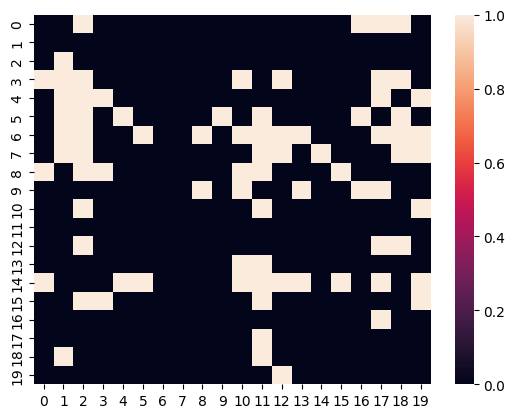

In [12]:
sns.heatmap(B_true)

In [29]:
def generate_full_interventional_set(B, n, sem_type, knockdown_eff=1.0, seed=0):
    assert knockdown_eff <= 1.0 and knockdown_eff >= 0.0
    set_random_seed_all(seed)
    d = B.shape[0]
    X_subsets = []
    perturbation_labels = []

    X, param_dict = simulation.simulate_nonlinear_sem(B_true, n, "mlp")
    X_subsets.append(X)
    perturbation_labels.append("obs")

    for i in range(d):
        X_int, _ = simulation.simulate_nonlinear_sem_knockdown(B_true, n, "mlp", param_dict, i, knockdown_eff=1.0)
        X_subsets.append(X_int)
        perturbation_labels.append(i)
    perturbation_label_col = pd.Series(sum([n * [p] for p in perturbation_labels], []))
    X_df = pd.DataFrame(np.vstack(X_subsets), columns=np.arange(d))
    X_df["perturbation_label"] = perturbation_label_col.astype("category")
    return X_df


In [30]:
X_df = generate_full_interventional_set(B_true, n, "mlp", knockdown_eff=1.0, seed=126)
X_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,perturbation_label
0,-16.616083,-12.063048,-6.770398,-1.036755,-9.955872,2.209979,-0.662305,-0.511210,3.191843,-9.442004,...,11.885525,5.927874,1.283760,-3.825516,-12.799652,-4.637507,-5.639800,-3.787172,-11.119689,obs
1,-24.877980,0.136228,-11.409936,9.117183,-5.958480,-10.617480,1.402867,1.285368,1.680851,-10.937607,...,7.771688,3.609760,-3.469877,4.462076,1.356381,-3.388739,-2.199593,-2.418158,-21.553930,obs
2,-19.484939,-0.488505,-12.729625,4.065504,-7.276144,-8.566341,-0.589999,1.093160,2.494853,-9.461160,...,5.738522,5.078703,0.075681,3.288379,-1.567157,1.062055,0.110735,-5.694713,-13.948243,obs
3,-18.827193,-3.040972,-14.514382,4.165101,-7.329138,-9.924133,0.104947,1.075252,1.501877,-8.498379,...,6.298008,6.282684,-2.720840,3.890888,-0.635339,2.956172,1.873573,-6.082060,-13.200521,obs
4,-18.057978,-8.230149,-3.843021,-5.235524,-8.513265,-0.809838,0.080411,-2.084304,2.248882,-8.356312,...,15.832411,-0.996870,0.741434,-6.871618,-23.947883,-3.554160,-1.325209,-1.862388,-7.827772,obs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-17.738478,-4.793414,-11.219491,3.960847,-7.905566,-9.543645,0.640482,0.410009,3.706537,-10.947159,...,9.494038,-6.324749,-1.167347,2.199750,-4.493161,4.563980,9.604521,6.637293,-0.000000,19
20996,-21.412666,-6.568461,-3.038400,9.168304,-8.594199,-10.094601,-0.394451,1.591406,4.019758,-9.275499,...,12.232341,-6.019426,-5.936012,6.442737,0.866037,-1.171110,5.502058,3.413930,-0.000000,19
20997,-18.597265,-14.371725,-3.772120,-4.498289,-12.268664,1.077783,0.402604,-1.874721,2.022923,-10.956116,...,12.870675,-6.078862,1.663955,-5.413249,-23.354574,-6.319987,-0.489308,-6.932879,-0.000000,19
20998,-24.565532,-6.457190,-14.106863,4.142013,-8.289822,-10.086369,-0.749704,0.505365,1.683673,-9.438886,...,1.720071,-4.341151,1.262518,2.299216,-3.207612,-4.195163,-0.943143,-0.653071,-0.000000,19


In [172]:
# KS Test based filtering
def compute_p_values(X_df):
    edge_rows = []
    d = X_df.shape[1] - 1
    observational_X_df = X_df[X_df.perturbation_label == "obs"]
    for target_gene_idx in tqdm(range(d)):
        for candidate_parent_idx in range(d):
            if target_gene_idx == candidate_parent_idx:
                continue
            cand_int_subset_df = X_df[X_df.perturbation_label == candidate_parent_idx]
            ks_stat, pval = scipy.stats.kstest(observational_X_df.loc[:, target_gene_idx].to_numpy(), cand_int_subset_df.loc[:, target_gene_idx].to_numpy())
            edge_rows.append((candidate_parent_idx, target_gene_idx, pval))
    edges_df = pd.DataFrame(edge_rows, columns=["candidate_parent_idx", "target_gene_idx", "pval"])
    
    # Compute BH corrected pvals
    edges_df = edges_df.sort_values("pval")
    n_pvals = edges_df.shape[0]
    edges_df["pval_rank"] = np.arange(1, edges_df.shape[0] + 1)
    edges_df["pval_adj"] = edges_df["pval"] * n_pvals / edges_df["pval_rank"]
    
    return edges_df

In [173]:
ks_edges_df = compute_p_values(X_df)
ks_edges_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 71.02it/s]


,candidate_parent_idx,target_gene_idx,pval,pval_rank,pval_adj
38,0,2,1.045272e-307,1,3.972033e-305
199,9,10,2.137618e-300,2,4.061474e-298
342,0,18,3.328318e-274,3,4.215870e-272
71,15,3,1.155158e-246,4,1.097400e-244
14,15,0,3.605090e-216,5,2.739869e-214


(array([139.,   6.,   3.,  11.,   8.,   3.,   8.,   7.,   6.,   7.,   4.,
          5.,   2.,   2.,   7.,   4.,   5.,   3.,   4.,   5.,   8.,   3.,
          2.,   5.,   4.,   3.,   6.,   5.,   2.,   6.,   0.,   2.,   0.,
          3.,   5.,   6.,   6.,   5.,   8.,   7.,   3.,   7.,   6.,   5.,
          2.,   2.,   8.,   7.,   6.,   9.]),
 array([3.97203322e-305, 1.99264917e-002, 3.98529833e-002, 5.97794750e-002,
        7.97059666e-002, 9.96324583e-002, 1.19558950e-001, 1.39485442e-001,
        1.59411933e-001, 1.79338425e-001, 1.99264917e-001, 2.19191408e-001,
        2.39117900e-001, 2.59044392e-001, 2.78970883e-001, 2.98897375e-001,
        3.18823867e-001, 3.38750358e-001, 3.58676850e-001, 3.78603342e-001,
        3.98529833e-001, 4.18456325e-001, 4.38382816e-001, 4.58309308e-001,
        4.78235800e-001, 4.98162291e-001, 5.18088783e-001, 5.38015275e-001,
        5.57941766e-001, 5.77868258e-001, 5.97794750e-001, 6.17721241e-001,
        6.37647733e-001, 6.57574225e-001, 6.775007

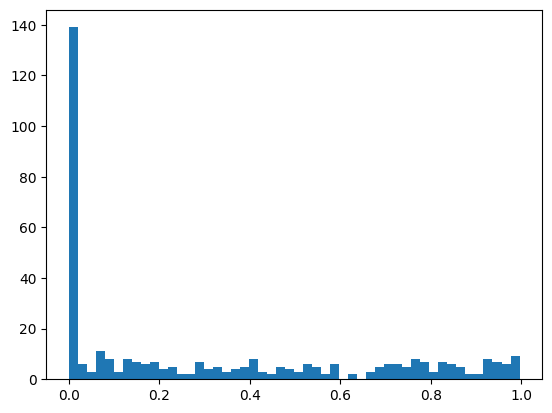

In [174]:
plt.hist(ks_edges_df["pval_adj"], bins=50)

In [175]:
ks_valid_edges_df = ks_edges_df[ks_edges_df["pval_adj"] <= 0.05].copy()
ks_valid_edges_df.head()

,candidate_parent_idx,target_gene_idx,pval,pval_rank,pval_adj
38,0,2,1.045272e-307,1,3.972033e-305
199,9,10,2.137618e-300,2,4.061474e-298
342,0,18,3.328318e-274,3,4.215870e-272
71,15,3,1.155158e-246,4,1.097400e-244
14,15,0,3.605090e-216,5,2.739869e-214


In [188]:
B_inf = np.zeros_like(B_true)
for row in ks_valid_edges_df.iterrows():
    B_inf[int(row[1]["candidate_parent_idx"]), int(row[1]["target_gene_idx"])] = 1

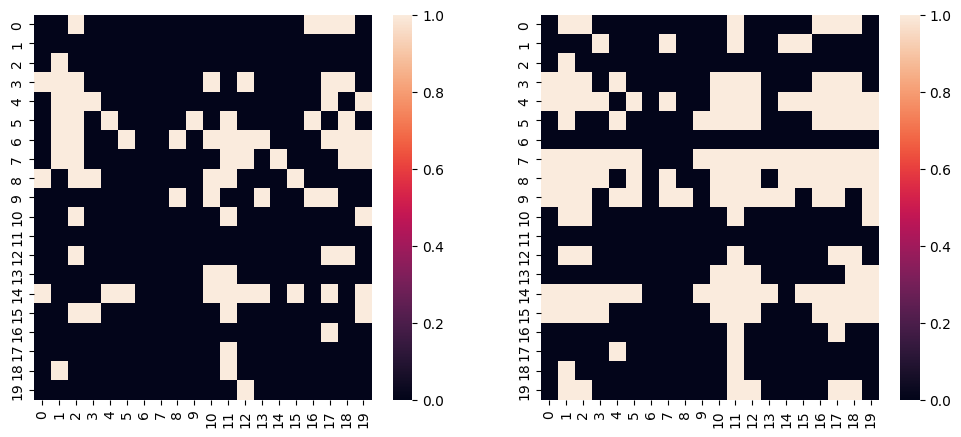

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(B_true, ax=ax[0])
sns.heatmap(B_inf, ax=ax[1])
plt.show()


In [179]:
recall = np.sum(B_true.astype(bool) & B_inf.astype(bool)) / np.sum(B_true)
precision = np.sum(B_true.astype(bool) & B_inf.astype(bool)) / np.sum(B_inf)
print(f"Recall: {recall} Precision: {precision}")

Recall: 0.85 Precision: 0.46258503401360546


In [205]:
# Precision recall curve as you change sig level.
B_pvals = np.zeros_like(B_true)
for row in ks_edges_df.iterrows():
    B_inf[int(row[1]["candidate_parent_idx"]), int(row[1]["target_gene_idx"])] = 1 - row[1]["pval_adj"]
precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(B_true.flatten(), B_inf.flatten())
n_edges = []
thresholds = np.append(thresholds, 1)
for t in thresholds:
    n_edges.append(np.sum(B_inf > t))
n_edges = np.array(n_edges)

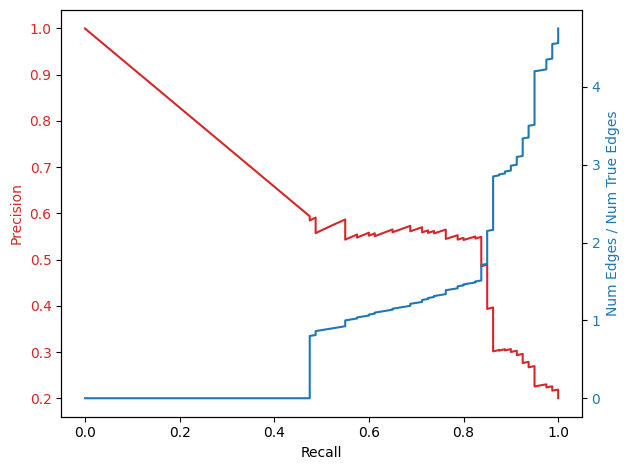

In [208]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision', color=color)
ax1.plot(recalls, precisions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Num Edges / Num True Edges', color=color)  # we already handled the x-label with ax1
ax2.plot(recalls, n_edges / np.sum(B_true), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [190]:
# Filter by max parents and plot recall by number of parents
ks_edges_parent_rank_dfs = []
for target_gene_idx, df in ks_edges_df.groupby("target_gene_idx"):
    df = df.sort_values("pval_adj", ascending=True)
    df["pval_adj_rank"] = np.arange(1, df.shape[0] + 1)
    ks_edges_parent_rank_dfs.append(df)
ks_edges_parent_rank_df = pd.concat(ks_edges_parent_rank_dfs)
ks_edges_parent_rank_df

,candidate_parent_idx,target_gene_idx,pval,pval_rank,pval_adj,pval_adj_rank
14,15,0,3.605090e-216,5,2.739869e-214,1
13,14,0,7.464625e-184,10,2.836557e-182,2
6,7,0,1.566776e-94,15,3.969165e-93,3
2,3,0,1.866672e-41,36,1.970376e-40,4
3,4,0,3.318344e-15,69,1.827494e-14,5
...,...,...,...,...,...,...
363,2,19,6.478149e-01,313,7.864845e-01,15
361,0,19,8.595454e-01,351,9.305620e-01,16
372,11,19,9.136894e-01,366,9.486393e-01,17
373,12,19,9.136894e-01,365,9.512383e-01,18


Text(0, 0.5, 'Recall')

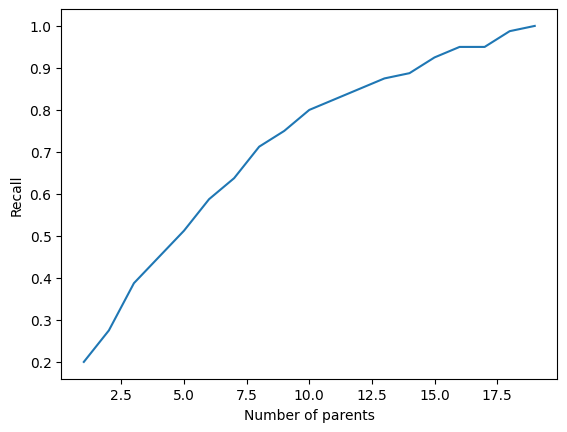

In [192]:
B_ranks = np.zeros_like(B_true) + d
for row in ks_edges_parent_rank_df.iterrows():
    B_ranks[int(row[1]["candidate_parent_idx"]), int(row[1]["target_gene_idx"])] = row[1]["pval_adj_rank"]

n_parents = list(range(1, 20))
recalls = []
B_true_bool = B_true.astype(bool)
for n_parent in n_parents:
    B_rank_thresh = B_ranks <= n_parent
    recalls.append(np.sum(B_true_bool & B_rank_thresh) / np.sum(B_true_bool))
    
plt.plot(n_parents, recalls)
plt.xlabel("Number of parents")
plt.ylabel("Recall")
    

In [138]:
# Try G^3 correlation tests
def compute_cross_p_values(X_df):
    edge_rows = []
    d = X_df.shape[1] - 1
    for int_gene_idx in tqdm(range(d + 1)):
        for candidate_parent_idx in range(d):
            for target_gene_idx in range(d):
                if target_gene_idx == candidate_parent_idx or target_gene_idx == int_gene_idx:
                    continue
                if int_gene_idx == d:
                    p_label = "obs"
                else:
                    p_label = int_gene_idx
                int_subset_df = X_df[X_df.perturbation_label == p_label]
                spearman_stat, pval = scipy.stats.spearmanr(int_subset_df.loc[:, candidate_parent_idx].to_numpy(), int_subset_df.loc[:, target_gene_idx].to_numpy())
                edge_rows.append((candidate_parent_idx, target_gene_idx, p_label, pval))
    edges_df = pd.DataFrame(edge_rows, columns=["candidate_parent_idx", "target_gene_idx", "int_gene_idx", "pval"])
    
    # Compute BH corrected pvals
    edges_df = edges_df.sort_values("pval")
    n_pvals = edges_df.shape[0]
    edges_df["pval_rank"] = np.arange(1, edges_df.shape[0] + 1)
    edges_df["pval_adj"] = edges_df["pval"] * n_pvals / edges_df["pval_rank"]
    
    return edges_df

In [139]:
cross_spearman_edges_df = compute_cross_p_values(X_df)
cross_spearman_edges_df.head()

  0%|                                                                                                                                                                                                                                                                                                                                                                                                              | 0/21 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/causalperturb/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

,candidate_parent_idx,target_gene_idx,int_gene_idx,pval,pval_rank,pval_adj
6638,7,15,18,0.0,1,0.0
6414,15,7,17,0.0,2,0.0
6775,15,7,18,0.0,3,0.0
3509,14,7,9,0.0,4,0.0
6771,15,3,18,0.0,5,0.0


(array([5414.,  116.,   82.,   82.,   70.,   82.,   54.,   68.,   40.,
          40.,   38.,   48.,   40.,   52.,   66.,   24.,   26.,   34.,
          11.,   47.,   18.,   31.,   25.,   20.,   34.,   20.,   28.,
          30.,   32.,   18.,   37.,   27.,   26.,   36.,   18.,   20.,
          28.,   30.,   22.,   26.,   16.,   33.,   33.,   36.,   22.,
          24.,   27.,   43.,   16.,   10.]),
 array([0.        , 0.02103255, 0.0420651 , 0.06309765, 0.0841302 ,
        0.10516275, 0.1261953 , 0.14722785, 0.1682604 , 0.18929295,
        0.2103255 , 0.23135805, 0.2523906 , 0.27342315, 0.2944557 ,
        0.31548825, 0.3365208 , 0.35755335, 0.3785859 , 0.39961845,
        0.42065099, 0.44168354, 0.46271609, 0.48374864, 0.50478119,
        0.52581374, 0.54684629, 0.56787884, 0.58891139, 0.60994394,
        0.63097649, 0.65200904, 0.67304159, 0.69407414, 0.71510669,
        0.73613924, 0.75717179, 0.77820434, 0.79923689, 0.82026944,
        0.84130199, 0.86233454, 0.88336709, 0.90439964, 

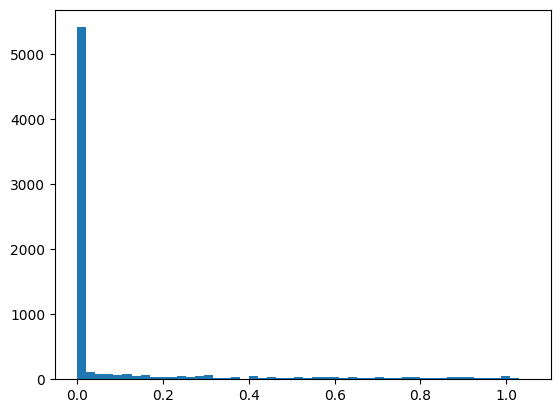

In [142]:
plt.hist(cross_spearman_edges_df["pval_adj"], bins=50)

In [161]:
agg_cross_spearman_edges_df = cross_spearman_edges_df.groupby(["target_gene_idx", "candidate_parent_idx"]).agg({"pval_adj": max})

# def sort_by_pval_adj(df):
#     return df.sort_values('pval_adj', ascending=True)

# sorted_groups = [sort_by_pval_adj(group) for _, group in agg_cross_spearman_edges_df.groupby("target_gene_idx")]
# for group in sorted_groups:
#     group["rank"] = np.arange(1, group.shape[0] + 1)


In [162]:
B_cross_inf = np.zeros_like(B_true)
for row in agg_cross_spearman_edges_df.iterrows():
    target, cand = row[0]
    p_val = row[1]["pval_adj"]
    B_cross_inf[cand, target] = p_val <= 0.05

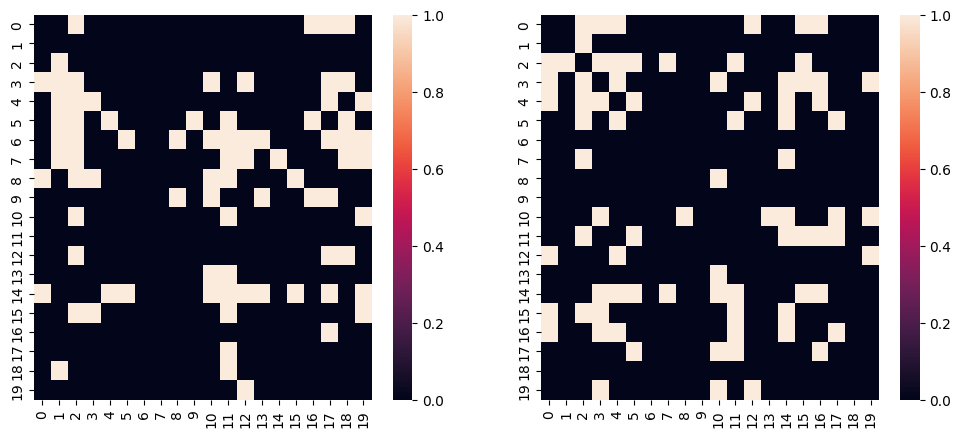

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(B_true, ax=ax[0])
sns.heatmap(B_cross_inf, ax=ax[1])
plt.show()


In [164]:
recall = np.sum(B_true.astype(bool) & B_cross_inf.astype(bool)) / np.sum(B_true)
precision = np.sum(B_true.astype(bool) & B_cross_inf.astype(bool)) / np.sum(B_cross_inf)
print(f"Recall: {recall} Precision: {precision}")

Recall: 0.3375 Precision: 0.3375


In [168]:
agg_cross_spearman_edges_df

pval_adj
target_gene_idx candidate_parent_idx              
0               1                     4.636180e-01
                2                     6.228803e-14
                3                     1.151687e-28
                4                     1.611580e-03
                5                     4.505513e-01
...                                            ...
19              14                    1.125604e-01
                15                    6.613208e-02
                16                    3.950301e-01
                17                    2.000852e-01
                18                    1.006669e+00

[380 rows x 1 columns]

In [170]:
# Precision recall curve as you change sig level.
B_cross_pvals = np.zeros_like(B_true)
for row in agg_cross_spearman_edges_df.iterrows():
    target, cand = row[0]
    B_cross_inf[cand, target] = 1 - row[1]["pval_adj"]
precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(B_true.flatten(), B_cross_inf.flatten())

Text(0, 0.5, 'Precision')

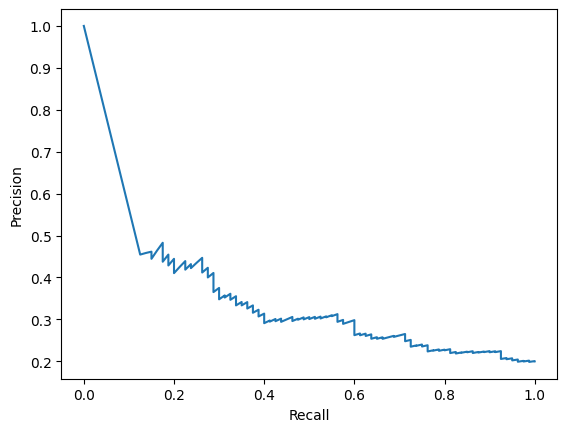

In [171]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")